<center><h1> Intelligent Systems </h1>
    <h2> <b>Assignment #2</b> </h2>
    <h3> Done by: Ghinea Cristian and Varga Zoltan </h3></center>

<h3> Abstract <h3>

<p> The notebook was run using google colab, and the data was uploaded to drive, therefore the path toward the dataset has to be personalized for each user. </p> 
<p> The dataset we choose contains images of leaves. These leaves belong to various plants such as apple trees, blueberry bush, cherry trees and corn. Among the images containing leaves we also have images which do not contain leaves in order to train our model for scenarios where it would not find any leaf. </p>
<p> The problem we address is to classify leaf images into species and also what disease it has if any. </p>
<p> The dataset is structured in the following way: it contains 3 folders train, validation and test. The validation and test contains 20%-20% of the total pictures, and the remaining 60% of images is in the training set. Also each of this folder has sub-folders containing the folders for each class. The dataset has in total 13828 images.</p>
<p> The dataset can be downloaded from <a href="https://www.tensorflow.org/datasets/catalog/plant_village"> here </a>

In [1]:
# include the libraries we will use
import os

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd

<h3> Load the data </h3>

In [2]:
# load the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_dir = os.path.join("/content/drive/MyDrive", "dataset")

# define the path towards the 3 sets: training, validation and test
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "validation")
test_dir = os.path.join(dataset_dir, "test")

In [4]:
# load the images into tensorflow datasets
train_dataset = image_dataset_from_directory(directory=train_dir, label_mode="categorical", image_size=(224, 224))
val_dataset = image_dataset_from_directory(directory=val_dir, label_mode="categorical", image_size=(224, 224))
test_dataset = image_dataset_from_directory(directory=test_dir, label_mode="categorical", image_size=(224, 224))

Found 8281 files belonging to 14 classes.
Found 2773 files belonging to 14 classes.
Found 2774 files belonging to 14 classes.


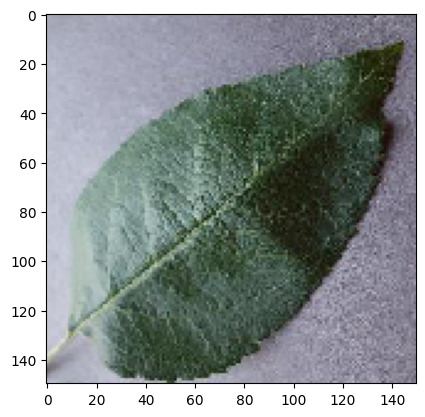

In [5]:
# visualize an image, and make sure it was loaded correctly
train_apple_healthy_dir = os.path.join(train_dir, "Apple___healthy")
filenames = [os.path.join(train_apple_healthy_dir, filename) for filename in os.listdir(train_apple_healthy_dir)]

idx = 302 # Change this if you want to look at a different apple leaf
some_example = load_img(filenames[idx], target_size=(150,150))

plt.imshow(some_example)

<h3> Model building </h3>

<p> We started by building a basic cnn with 4 convolutional layers, between each a MaxPooling layer to reduce the output size at each layer. After that we flattened the 2D layers. By flattenning in the upcoming layers we lost the neighborhood information, but this allows us to have some layers on the top densly connected, which means we can learn very high level features introduce some non-linearities to model complex relationships.</p>
<p> As activation function we used the relu (which is a linear function with 0 on the negative side), this helps us combat the vanishing gradient problem when doing backpropagation. </p>
<p> As expected the output layer contains 14 nodes, because we have 14 classes and uses the sigmoid function to transform the output values into probabilities.</p> 
<p> The loss function we choose is categorical cross entropy as we are performing multiclass classification </p> 

In [6]:
inputs_without_augmentation = Input(shape=(224, 224, 3)) # resize the images to have 224x224 and keep the color information
x_who_aug = Rescaling(scale=1./255)(inputs_without_augmentation) # rescale the values from [0,255] -> [0,1]

#START convolutional + maxpooling layers
x_who_aug = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x_who_aug) # 1st conv. layer with 128 neurons
x_who_aug = MaxPooling2D(pool_size=(2, 2))(x_who_aug) # pool size of 2x2 means the ouput of the previous layer will be halved
x_who_aug = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x_who_aug) # 2nd conv. layer with 128 neurons
x_who_aug = MaxPooling2D(pool_size=(2, 2))(x_who_aug)
x_who_aug = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x_who_aug) # 3rd conv. layer with 64 neurons
x_who_aug = MaxPooling2D(pool_size=(2, 2))(x_who_aug)
x_who_aug = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x_who_aug) # 4th conv. layer with 32 neurons
x_who_aug = MaxPooling2D(pool_size=(2, 2))(x_who_aug)
# END convolutional + maxpooling layers

x_who_aug = Flatten()(x_who_aug) # flatten the 2d network into 1d
x_who_aug = Dense(512, activation="relu")(x_who_aug) # make a dense layer
outputs_who_aug = Dense(14, activation="sigmoid")(x_who_aug) # apply sigmoid to have probabilities

convnet_who_aug = Model(inputs_without_augmentation, outputs_who_aug)

convnet_who_aug.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

<p> We choose to run the training for 30 epochs, but we also deployed early stopping. This prevents us from overfitting by stopping the training when the training loss begins to differ by a great extent from the validation loss.</p> 

In [7]:
convnet_history_who_aug = convnet_who_aug.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<p> One can se on the diagram below that the model shows signs of overfitting (validation loss is much higher than training loss). Thus in de followings we tried to combat overfitting. </p>

<Axes: >

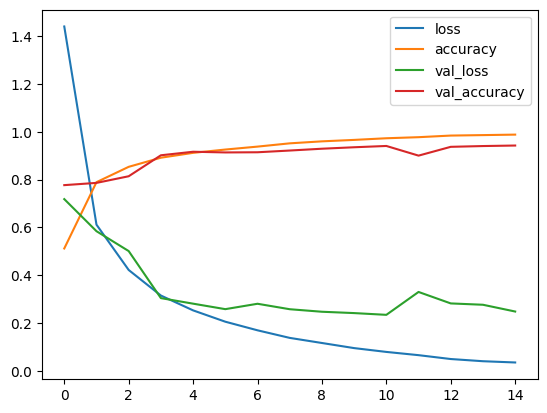

In [8]:
pd.DataFrame(convnet_history_who_aug.history).plot()

<h3> Fight agains overfitting </h3>

<p> As a first weapon agains overfitting we used data augmentation. We utilized all the possible ways of manipulating the original image: zooming, flipping, rotation, and translating.</p>
<p> To have a grasp how the data after augmentation will look like we applied it for one image from the dataset first.</p>
<p> It must be said that it isn't that different from the original images. </p>

In [9]:
augmentation_layers = Sequential([
   Input(shape=(224, 224, 3)),
   RandomFlip(mode="horizontal"),
   RandomRotation(factor=0.1),
   RandomZoom(height_factor=(-0.2, 0.2)),
   RandomTranslation(height_factor=0.2, width_factor=0.2)
])

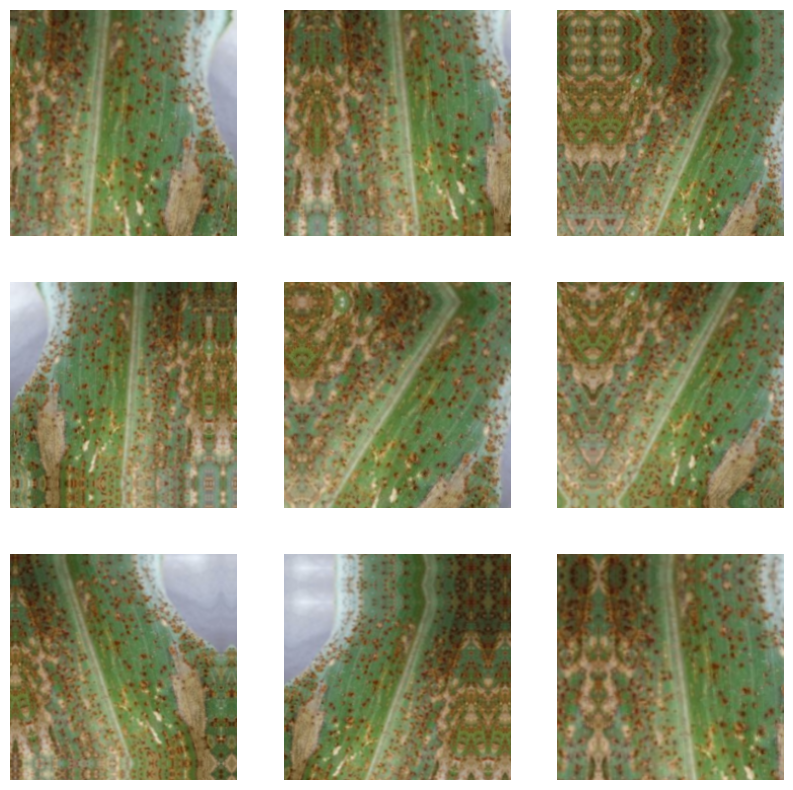

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = augmentation_layers(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

<p> As another way of combating overfitting we used drop-out after some layers. Drop-out sets the weights of some randomly choosen nodes (the probability is specified as argument) to 0. This way not all the nodes will participate in the decision during a training iteration. 
 This means nodes that relied on them have to readjust their weights.</p>

In [11]:
inputs = Input(shape=(224, 224, 3))

# Put the augmentation layers
# START augmentation layers
x = RandomFlip(mode="horizontal")(inputs)
x = RandomRotation(factor=0.1)(x)
x = RandomZoom(height_factor=(-0.2, 0.2))(x)
x = RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
# END augmentation layers

x = Rescaling(scale=1./255)(inputs) # rescale the values from [0;255] -> [0;1]

#START convolutional + maxpooling layers + droupouts
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# END convolutional + maxpooling layers + dropouts

x = Flatten()(x) # flatten the 2d network into 1d
x = Dense(512, activation="relu")(x) # make a dense layer
x = Dropout(0.5)(x) 
x = Dense(512, activation="relu")(x) # make a dense layer
x = Dropout(0.5)(x)

outputs = Dense(14, activation="sigmoid")(x) # apply sigmoid to have probabilities
convnet = Model(inputs, outputs)
convnet.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [12]:
convnet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 128)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                       

In [13]:
convnet_history = convnet.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<Axes: >

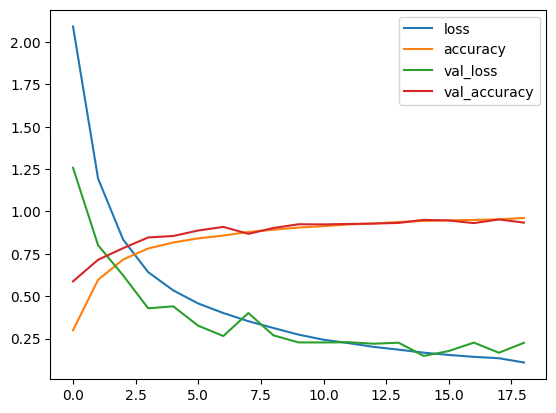

In [14]:
pd.DataFrame(convnet_history.history).plot()

<p> We wanted to see how the model performs on actual given examples so we choose 4 images and asked to model to predict based on them. </p> 
<p> The first image, which belongs to background without leaves (5) category it predicted background with a certainty of <b>0.97</b>. </p>
<p> The second image was a healthy blueberry leaf (6). And it was predicted with a certainty of <b>0.99</b>. </p>
<p> The third image was a Cherry leaf with powdery mildew (8) on it, this was predicted with a certainty of <b>0.00004</b>, which is a miss. The model thought that it is a healthy cherry leaf.</p>
 <p> The last image was a corn leaf with common rust (10), it was predicted with a probability of <b>0.99</b> </p>

In [15]:
demo_dataset = image_dataset_from_directory(
    directory=os.path.join("/content/drive/MyDrive", "dataset/demo/"), shuffle=False, label_mode=None, image_size=(224, 224), )

Found 4 files belonging to 1 classes.


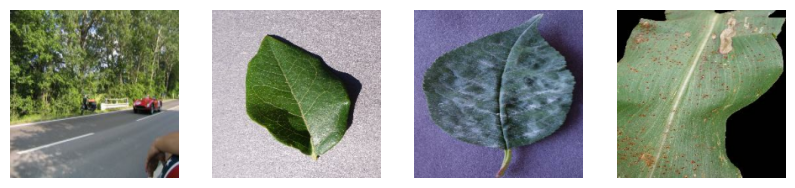

In [16]:
plt.figure(figsize=(10, 10))
for batch in demo_dataset:
    for i, img in enumerate(batch):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.axis("off")

In [17]:
convnet.predict(demo_dataset)

1/1 [==============================] - 0s 262ms/step


array([[4.10692301e-03, 4.91760164e-01, 1.71786160e-04, 2.19446197e-01,
        9.77156281e-01, 6.31834206e-04, 9.07687545e-02, 3.07423732e-04,
        5.83083808e-01, 3.84974107e-02, 1.21300459e-01, 1.02751760e-03,
        1.30312331e-03, 2.43463874e-01],
       [2.24976048e-01, 3.01830787e-02, 4.07602757e-01, 8.98484707e-01,
        4.31126362e-04, 9.99993920e-01, 3.90511267e-02, 2.04994902e-01,
        6.82044338e-05, 2.72281181e-06, 2.84545880e-04, 1.13146996e-06,
        8.61517936e-02, 1.02264490e-02],
       [4.26445246e-01, 1.42220510e-02, 1.27629492e-05, 6.97554827e-01,
        2.95171171e-01, 1.72610904e-04, 9.99950051e-01, 4.03899976e-05,
        1.06412626e-04, 4.93971056e-05, 7.24328784e-05, 4.27157589e-04,
        2.97147672e-05, 1.62352753e-05],
       [8.68373178e-03, 2.06259526e-02, 1.47736846e-05, 1.42526274e-04,
        1.88832685e-01, 6.30246432e-05, 2.13791262e-02, 6.54458650e-04,
        1.21644095e-01, 9.99990582e-01, 2.99895164e-02, 3.12068284e-01,
        3.757

<h3> Transfer learning <h3>

<p> We tried to improve the performance of our models by using an already trained model, namely Resnet50. This model was trained on a huge number of real-life pictures, so it should be able in the first place to distingush leaves from other objects. At least this is what we expected from it.</p>

In [18]:
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [19]:
resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

<p> We added the resnet layer at the bottom of our layers, and we have put on top of it 2 convolutional layers and 3 dense layers to make it work four our task</p>

In [20]:
inputst = Input(shape=(224, 224, 3))
xt = preprocess_input(inputst)

# START augmentation layers
xt = RandomFlip(mode="horizontal")(inputst)
xt = RandomRotation(factor=0.1)(xt)
xt = RandomZoom(height_factor=(-0.2, 0.2))(xt)
xt = RandomTranslation(height_factor=0.2, width_factor=0.2)(xt)
# END augmentation layers

xt = Rescaling(scale=1./255)(inputst) # rescale the values from [0;255] -> [0;1]

# START Xception layer
xt = resnet50_base(xt) # integrate the resnet layer
# END Xception layer

#START convolutional + maxpooling layers
xt = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(xt) # 1st conv. layer with 64 neurons
xt = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(xt) # 2nd conv. layer with 32 neurons
xt = MaxPooling2D(pool_size=(2, 2))(xt)
# END convolutional + maxpooling layers

xt = Flatten()(xt) # flatten the 2d network into 1d
xt = Dense(1024, activation="relu")(xt) # make a dense layer
xt = Dropout(0.35)(xt)
xt = Dense(512, activation="relu")(xt) # make a dense layer
xt = Dropout(0.35)(xt)
xt = Dense(256, activation="relu")(xt) # make a dense layer

outputs_transfer_model = Dense(14, activation="sigmoid")(xt) # apply sigmoid to have probabilities at the output layer
transfer_model = Model(inputst, outputs_transfer_model)

<p> Lock the resnet, not to loose the pre-trained weights.</p>

In [21]:
resnet50_base.trainable = False

In [22]:
transfer_model.compile(optimizer=RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
transfer_model_history = transfer_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<p> From this diagram we can se that the model with the resnet doesn't perform as well as expected</p>

<Axes: >

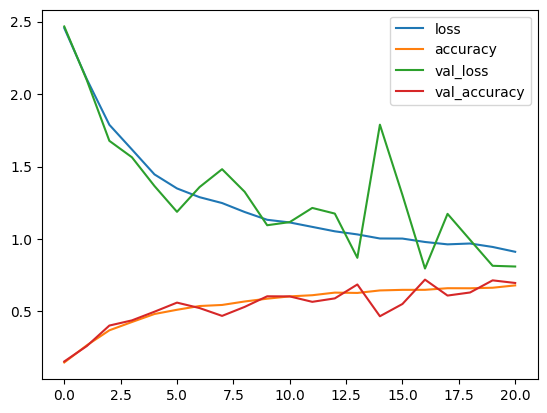

In [24]:
pd.DataFrame(transfer_model_history.history).plot()

<h3> Testing on the test set </h3>

In [25]:
# Convnet without augmentation
test_loss_who, test_acc_who = convnet_who_aug.evaluate(test_dataset)
test_acc_who

87/87 [==============================] - 48s 500ms/step - loss: 0.2258 - accuracy: 0.9297


0.9297044277191162

In [26]:
# With augmentation + dropout
test_loss, test_acc = convnet.evaluate(test_dataset)
test_acc

87/87 [==============================] - 1s 15ms/step - loss: 0.1578 - accuracy: 0.9466


0.9466474652290344

In [27]:
# With transfer learning
test_loss, test_acc = transfer_model.evaluate(test_dataset)
test_acc

87/87 [==============================] - 2s 24ms/step - loss: 0.7895 - accuracy: 0.7249


0.7249459028244019

<h3> Conclusions </h3>

<p> We are pretty satisfied with the first two models, they performed as expected from our point of view. Since the second model has a better score, than the first one means we successfully reduced overfitting, which was clearly visible in the first model. </p> 
<p> On the other hand, we had higher expectations from the model with transfer learning, because it should have already been able to distinguish from pictures that contain leaves and images that don't. But the practice says that we only complicated the model, and it is not able to distinguish from diseases. Maybe another layer architecture on the top would have helped </p>